In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import matplotlib
from sklearn import preprocessing
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline


## Загрузка датасета

In [2]:
data = pd.read_csv("eshop.csv")

In [3]:
grouped_sub_list = data.groupby(by = "Customer ID")["Subtotal"].apply(list)
grouped_sub_df = pd.DataFrame(grouped_sub_list)
data["Date"] = pd.to_datetime(data["Date"])
grouped_date_list = data.groupby(by = "Customer ID")["Date"].apply(list)
idx_list = list(grouped_sub_df.index)

## Создание функций "Давность", "Частота", "Деньги" и "ID".

In [4]:
total_sum_list = []
total_count_list = []
last_date = []
for el in grouped_sub_list:
    total_sum_list.append(sum(el))
    total_count_list.append(len(el))
    
total_sum = pd.DataFrame({"Monetary" : total_sum_list})
total_count = pd.DataFrame({"Frequency" : total_count_list})


for el in grouped_date_list:
    last_date.append((pd.to_datetime("19/12/2015") - max(el)).days)
    
date = pd.DataFrame({"Recency" :last_date})
idx = pd.DataFrame({"ID" :idx_list})

## Создание RFM датасета

In [5]:
rfm = pd.concat([idx, date, total_count, total_sum], axis = 1)

## ID не является гиперпарам задачи, поэтому мы удаляем этот столбец и делаем по нему индексы

In [6]:
rfm.index = rfm["ID"]
rfm = rfm.drop(columns="ID")

In [7]:
rfm = np.array(rfm)

## Настройки граффика


In [8]:
plt.rc('figure',figsize = [15, 10])
plt.rc('axes', titlesize=20)  
plt.rc('axes', labelsize=18)

LABEL_COLOR_MAP = {0 : 'y', 1 : 'g', 2 : 'b', 3 : 'c', 4 : 'm', 5 : 'r', 6 : 'k'}

# k-means

##Мой прогноз количества кластеров - 3. Мы покажем точки RFM на трехмерном графике.

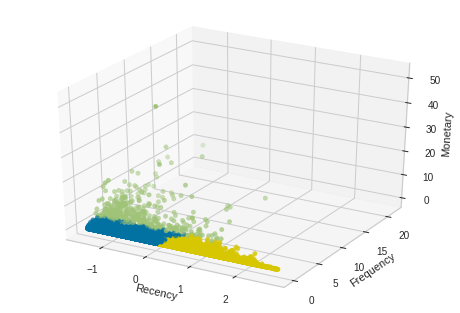

In [14]:
kmeans = KMeans(n_clusters=3, random_state=0).fit(rfm)
label_color = [LABEL_COLOR_MAP[l] for l in kmeans.labels_]
ax = plt.figure().add_subplot(111, projection='3d')
ax.scatter(rfm[:,0],rfm[:,1],rfm[:,2],color=label_color)
ax.set_xlabel("Recency")
ax.set_ylabel("Frequency")
ax.set_zlabel("Monetary")
plt.show()

## Мы определяем кластеры по расстоянию, поэтому мы видим, что, поскольку точки не нормализированые, некоторые измерения имеют больше значения, чем другие. Следовательно, мы нормализуем точки так, чтобы каждая точка rmf находилась в диапазоне [0-1].

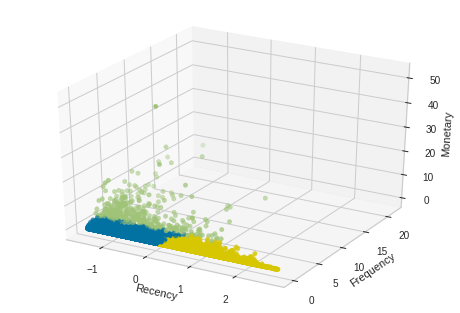

In [15]:
rfm = preprocessing.StandardScaler().fit_transform(rfm)
kmeans = KMeans(n_clusters=3, random_state=0).fit(rfm)
label_color = [LABEL_COLOR_MAP[l] for l in kmeans.labels_]
ax = plt.figure().add_subplot(111, projection='3d')
ax.scatter(rfm[:,0],rfm[:,1],rfm[:,2],color=label_color)
ax.set_xlabel("Recency")
ax.set_ylabel("Frequency")
ax.set_zlabel("Monetary")
plt.show()

## Находим лучшее количество кластеров сначала методом локтя, а потом методом силуэта

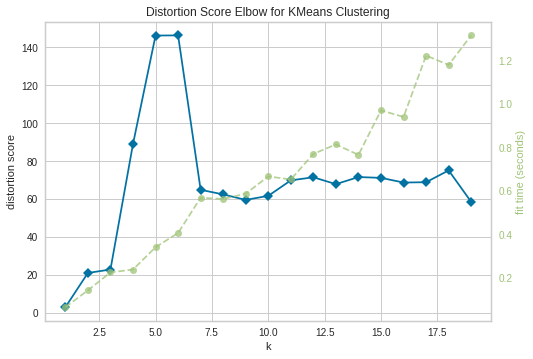

In [12]:
from yellowbrick.cluster import KElbowVisualizer

model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,20))

visualizer.fit(rfm)

visualizer.poof()

# Метод силлуета

For n_clusters = 2 The average silhouette_score is : 0.7225663016322099
For n_clusters = 3 The average silhouette_score is : 0.4699994399565772
For n_clusters = 4 The average silhouette_score is : 0.48286984542745764
For n_clusters = 5 The average silhouette_score is : 0.48945430191435413
For n_clusters = 6 The average silhouette_score is : 0.41865395732371397
For n_clusters = 7 The average silhouette_score is : 0.42149372765077164
For n_clusters = 8 The average silhouette_score is : 0.42550667217806204
For n_clusters = 9 The average silhouette_score is : 0.3746209457506811
For n_clusters = 10 The average silhouette_score is : 0.37833035479725
For n_clusters = 11 The average silhouette_score is : 0.3985484009918067
For n_clusters = 12 The average silhouette_score is : 0.3987579696044995
For n_clusters = 13 The average silhouette_score is : 0.4034308216777025
For n_clusters = 14 The average silhouette_score is : 0.40309250694512305
For n_clusters = 15 The average silhouette_score is : 0

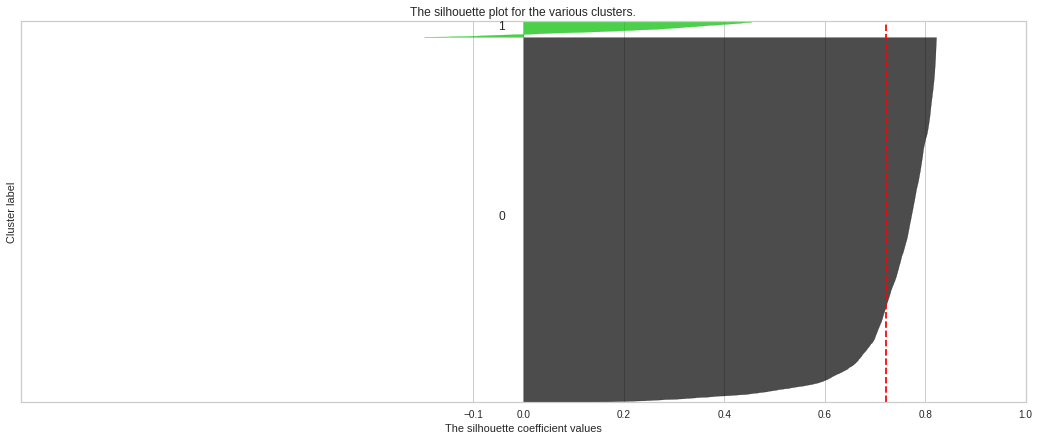

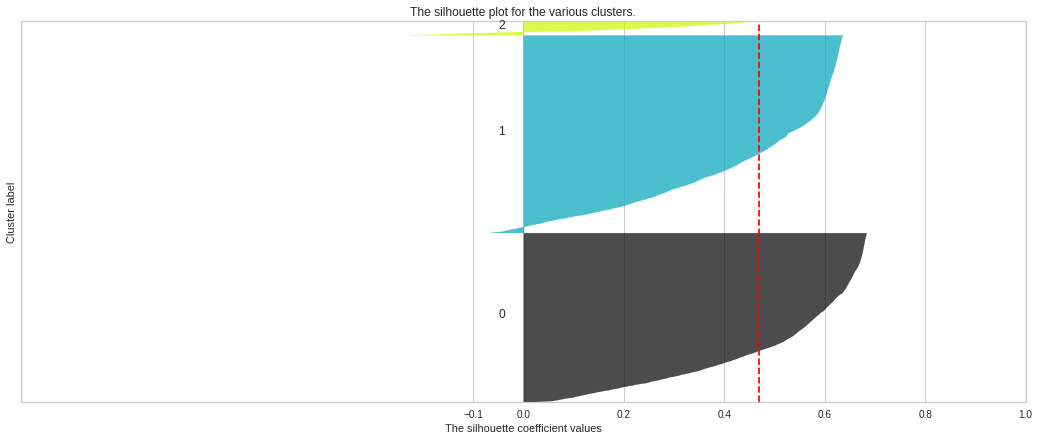

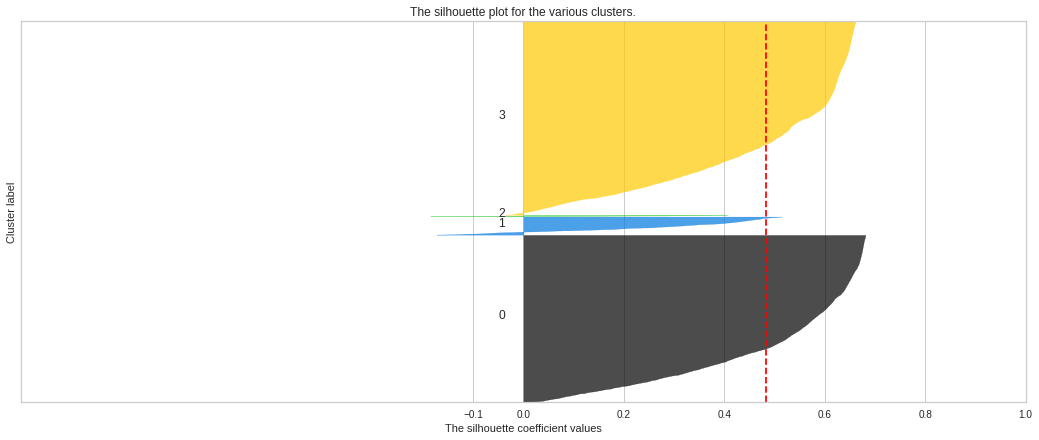

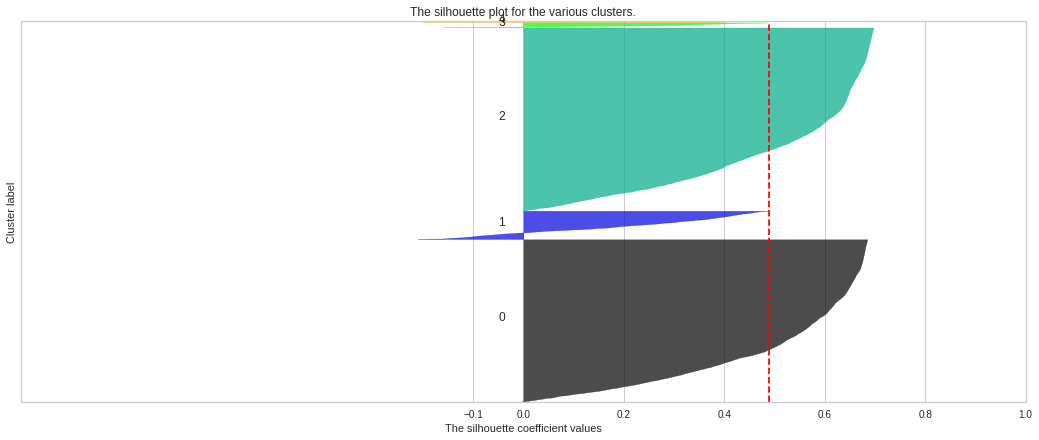

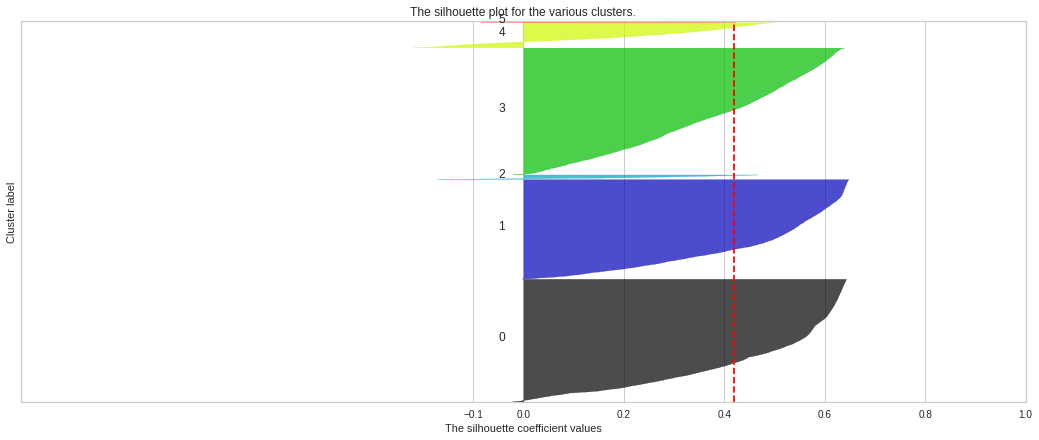

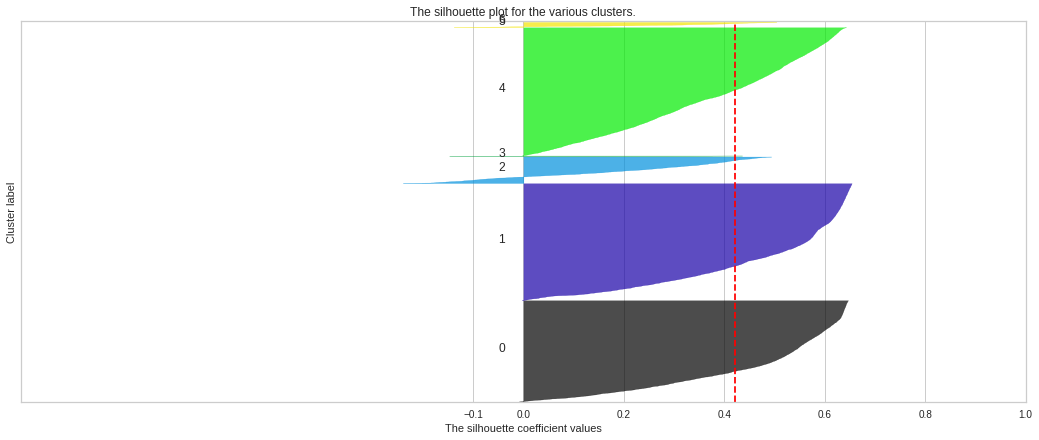

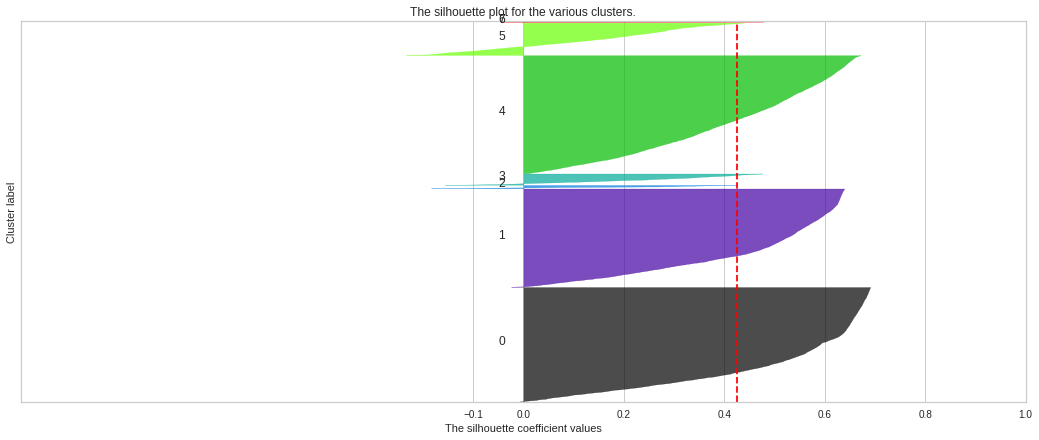

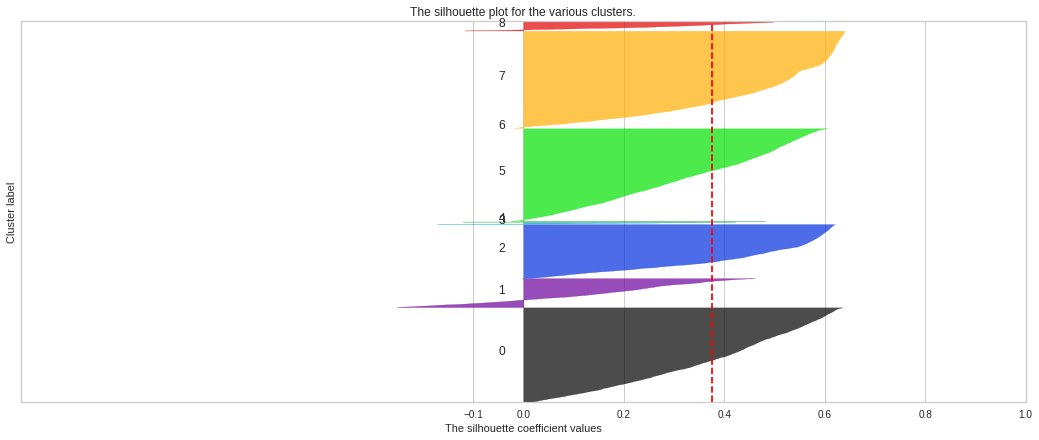

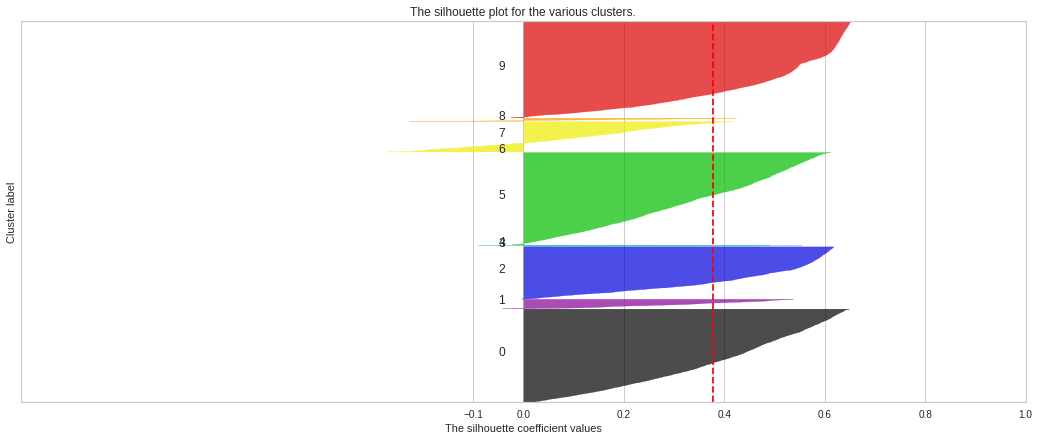

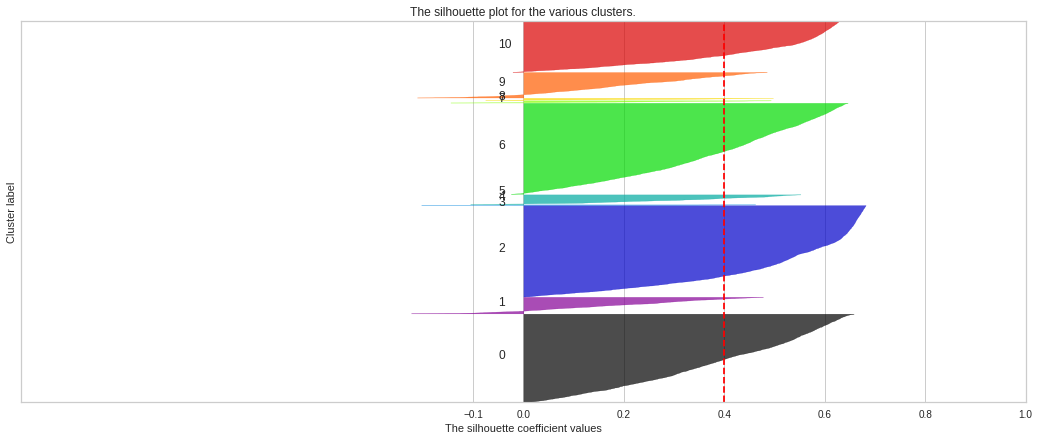

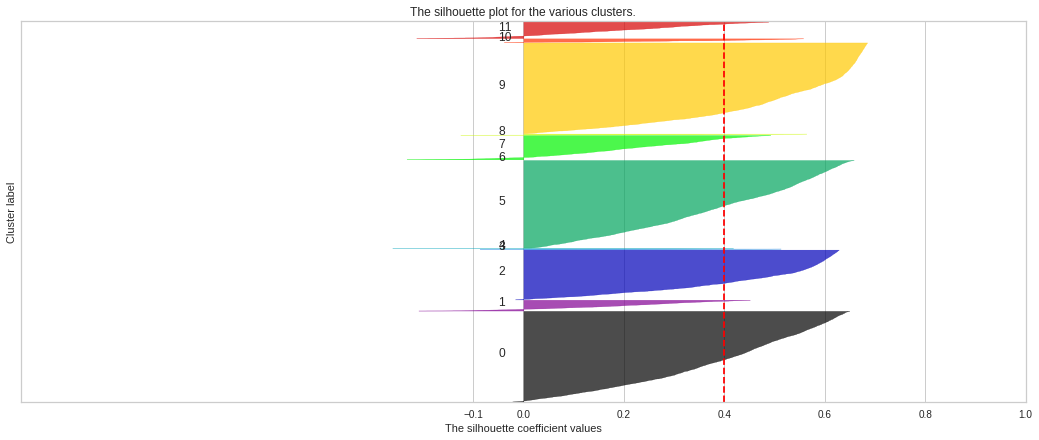

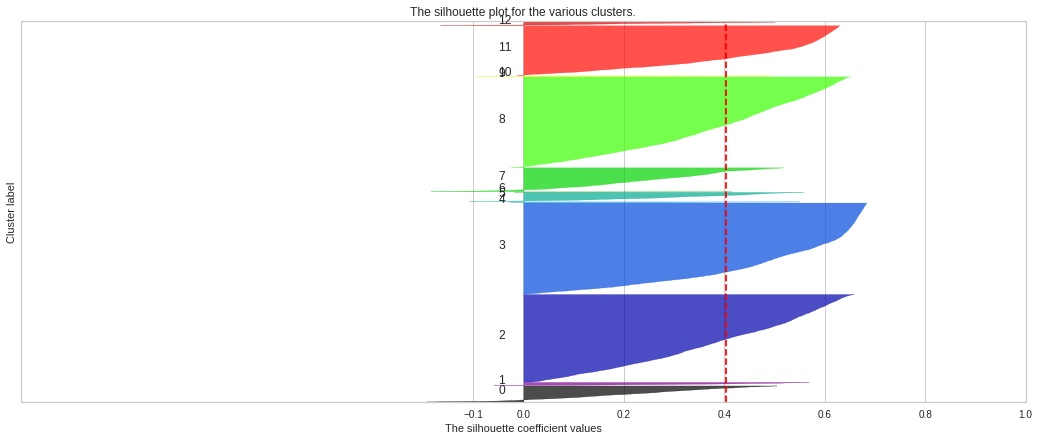

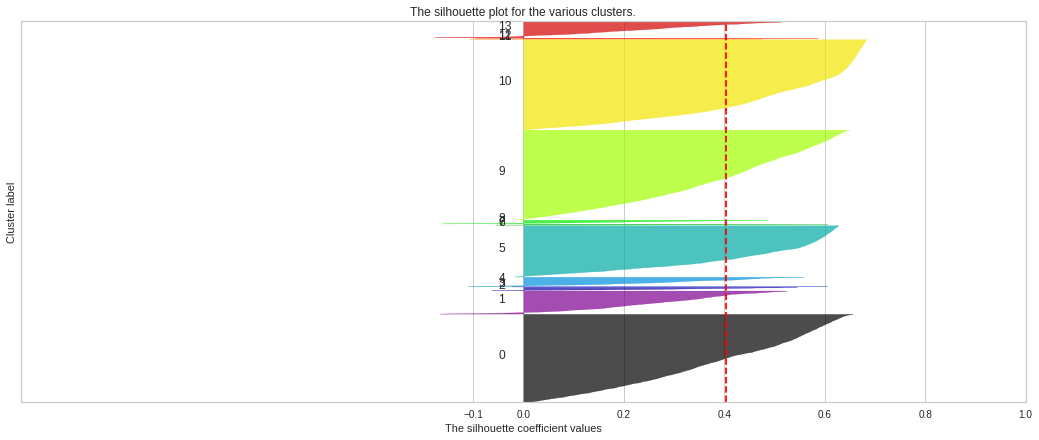

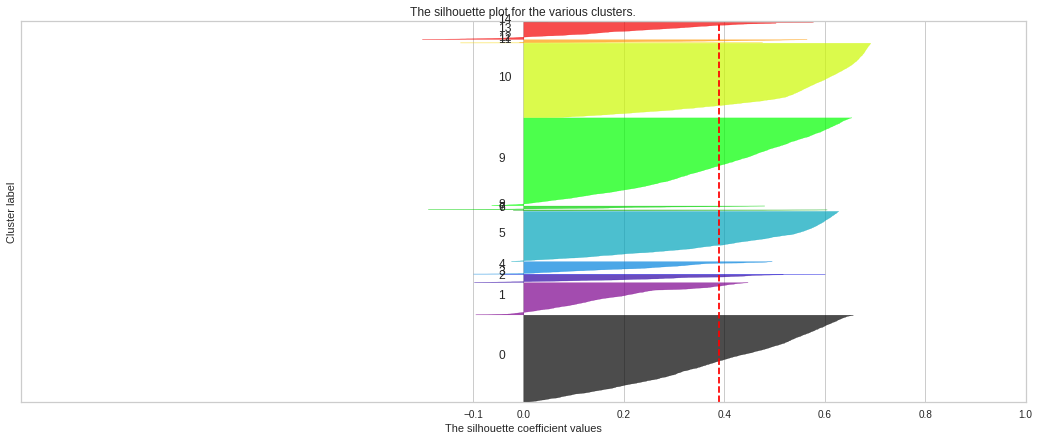

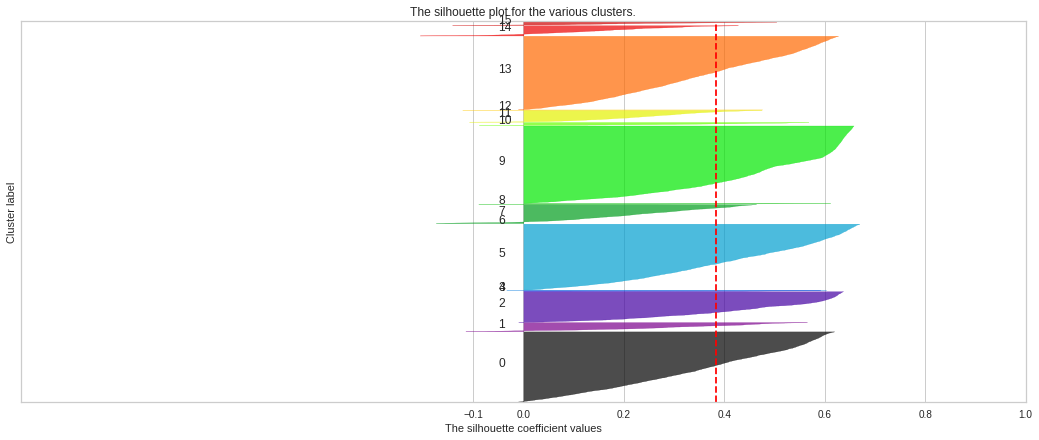

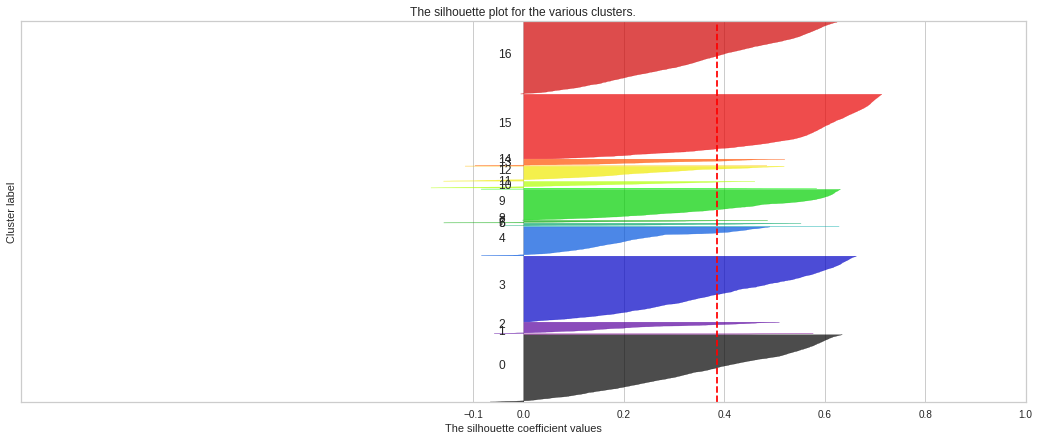

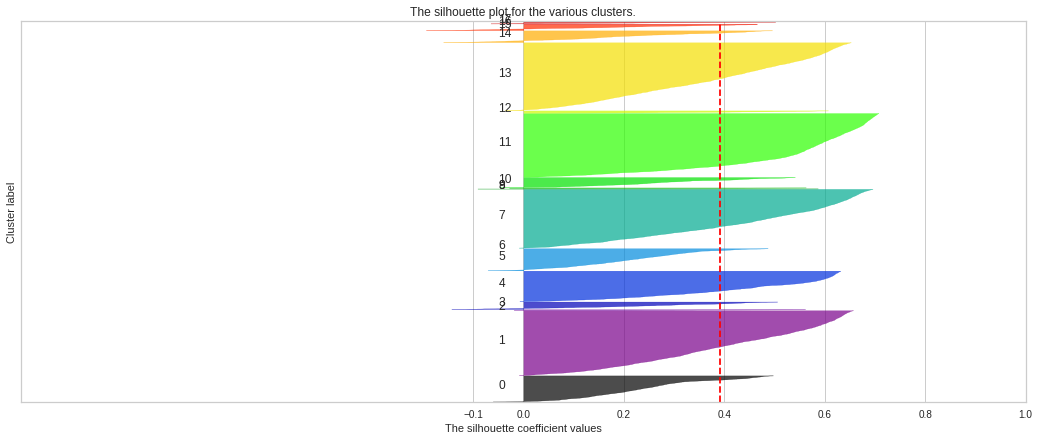

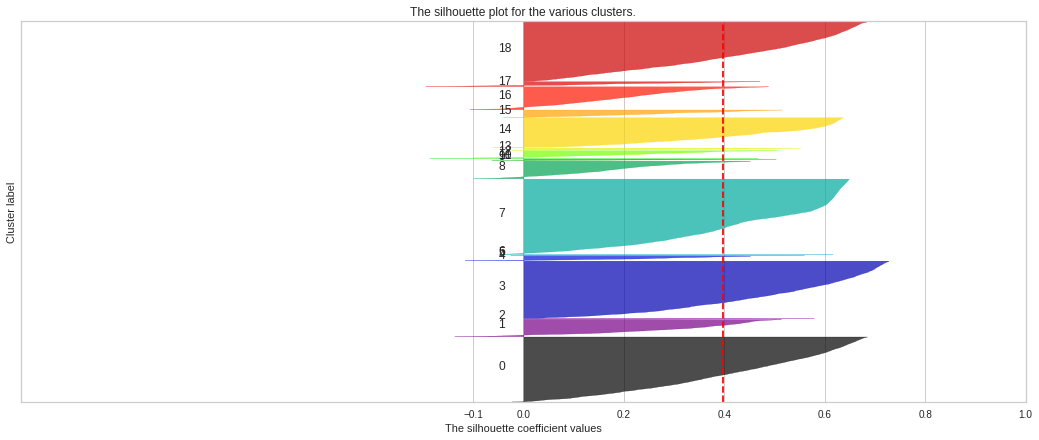

In [13]:
for n_clusters in range(2,20):
    fig, (ax1) = plt.subplots(1)
    fig.set_size_inches(18, 7)

    
    ax1.set_xlim([-1, 1])

    ax1.set_ylim([0, len(rfm) + (n_clusters + 1) * 10])

    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(rfm)

    silhouette_avg = silhouette_score(rfm, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    sample_silhouette_values = silhouette_samples(rfm, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10
    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

plt.show()

### Значение n_clusters 6-19 выглядит неоптимальным для данных данных по следующим причинам:
1. Оценка меньше 0,4 означает, что данные, принадлежащие кластерам, могут быть неверными / неверными. В этих случаях есть такие значения.
2. Широкие колебания размеров участков силуэта. В некоторых случаях наблюдается сильная заточка к концу относительно общей ширины сегмента.

### На мой взгляд, наиболее оптимальным количеством кластеров является k = 4. Видим, что большинство его точек имеют коэффициенты силуэта больше, чем средний коеф силуэта. Толщина силуэтного графика, представляющего каждый кластер, также является показателем. Для граффика с числом кластеров 4 толщина более равномерная.

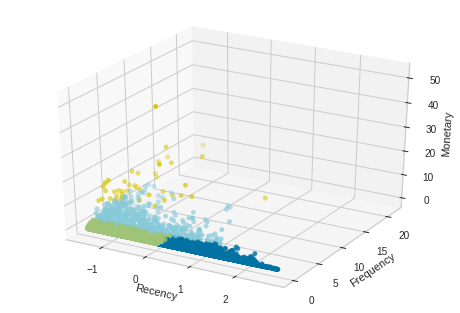

In [16]:
rfm = preprocessing.StandardScaler().fit_transform(rfm)
kmeans = KMeans(n_clusters=4, random_state=0).fit(rfm)
label_color = [LABEL_COLOR_MAP[l] for l in kmeans.labels_]
ax = plt.figure().add_subplot(111, projection='3d')
ax.scatter(rfm[:,0],rfm[:,1],rfm[:,2],color=label_color)
ax.set_xlabel("Recency")
ax.set_ylabel("Frequency")
ax.set_zlabel("Monetary")
plt.show()